Note:
1. In order to run this notebook, please ensure that you have the required libraries installed and the dataset available in the specified relative path `../data`.
2. The real-time predictor app runs on `streamlit` and needs a folder for dumping the model artifacts.
A visual representation of the folder hierarchy expected for the overall project is as follows:

```text
media-success-prediction/
│── code/
│   ├── media_success_prediction.ipynb
│   ├── real_time_predictor.py
│   └── synthetic_sentiment_data.py
│── data/
│   ├── spotify_data.csv
│   ├── billboard_data.csv
│   ├── audio_features.csv
│   ├── sentiment.csv (generated)
│   └── merged_data.csv (generated)
│   └── extracts/
│       ├── log_reg_model.pkl (generated)
│       ├── feature_columns.csv (generated)
│       └── feature_summary.csv (generated)
```
3. Refer to the github repo to download the entire project folder: [media-success-prediction](https://github.com/priyadarshanparida/media-success-prediction)


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
import shap

## 1. Data Preparation – Data Pre-processing

In [41]:
# Path to the data directory
DATA_DIR = Path("../data")

In [42]:
# ---------- Helper Functions ----------
def normalize_name(s: str) -> str:
    """Lowercase, strip, remove punctuation, drop '(feat...)' parts, collapse spaces."""
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    s = re.sub(r"[’'`]", "", s)              # apostrophes and smart quotes
    s = re.sub(r"\s*\(.*?\)\s*", " ", s)     # remove anything in parentheses
    s = re.sub(r"\s+feat\..*", "", s)        # remove 'feat.' trailers
    s = re.sub(r"\s+ft\..*", "", s)          # remove 'ft.' trailers
    s = re.sub(r"[^a-z0-9\s]", " ", s)       # non-alphanum -> space
    s = re.sub(r"\s+", " ", s)               # collapse whitespace
    return s.strip()

def read_csv(path: Path, **kwargs) -> pd.DataFrame:
    df = pd.read_csv(path, **kwargs)
    print(f"Loaded {path.name}: {df.shape[0]:,} rows x {df.shape[1]} cols")
    return df

In [43]:
billboard = read_csv(DATA_DIR / "billboard.csv")
audio = read_csv(DATA_DIR / "audio_features.csv")
spotify = read_csv(DATA_DIR / "spotify_songs.csv")

Loaded billboard.csv: 327,895 rows x 10 cols
Loaded audio_features.csv: 29,503 rows x 22 cols
Loaded spotify_songs.csv: 32,833 rows x 23 cols


In [44]:
# Billboard
billboard["song_norm"] = billboard["song"].apply(normalize_name)
billboard["artist_norm"] = billboard["performer"].apply(normalize_name)

# Audio features
audio["song_norm"] = audio["song"].apply(normalize_name)
audio["artist_norm"] = audio["performer"].apply(normalize_name)

# Spotify songs
spotify["song_norm"] = spotify["track_name"].apply(normalize_name)
spotify["artist_norm"] = spotify["track_artist"].apply(normalize_name)

In [45]:
display(billboard.info())
display(audio.info())
display(spotify.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   url                     327895 non-null  object 
 1   week_id                 327895 non-null  object 
 2   week_position           327895 non-null  int64  
 3   song                    327895 non-null  object 
 4   performer               327895 non-null  object 
 5   song_id                 327895 non-null  object 
 6   instance                327895 non-null  int64  
 7   previous_week_position  295941 non-null  float64
 8   peak_position           327895 non-null  int64  
 9   weeks_on_chart          327895 non-null  int64  
 10  song_norm               327895 non-null  object 
 11  artist_norm             327895 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 30.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29503 entries, 0 to 29502
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   song_id                    29503 non-null  object 
 1   performer                  29503 non-null  object 
 2   song                       29503 non-null  object 
 3   spotify_genre              27903 non-null  object 
 4   spotify_track_id           24397 non-null  object 
 5   spotify_track_preview_url  14491 non-null  object 
 6   spotify_track_duration_ms  24397 non-null  float64
 7   spotify_track_explicit     24397 non-null  object 
 8   spotify_track_album        24391 non-null  object 
 9   danceability               24334 non-null  float64
 10  energy                     24334 non-null  float64
 11  key                        24334 non-null  float64
 12  loudness                   24334 non-null  float64
 13  mode                       24334 non-null  flo

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

None

In [46]:
display(billboard.head())
display(audio.head())
display(spotify.head())

,url,week_id,week_position,song,performer,song_id,instance,previous_week_position,peak_position,weeks_on_chart,song_norm,artist_norm
0,http://www.billboard.com/charts/hot-100/1965-0...,7/17/1965,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4,dont just stand there,patty duke
1,http://www.billboard.com/charts/hot-100/1965-0...,7/24/1965,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5,dont just stand there,patty duke
2,http://www.billboard.com/charts/hot-100/1965-0...,7/31/1965,14,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,22.0,14,6,dont just stand there,patty duke
3,http://www.billboard.com/charts/hot-100/1965-0...,8/7/1965,10,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,14.0,10,7,dont just stand there,patty duke
4,http://www.billboard.com/charts/hot-100/1965-0...,8/14/1965,8,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,10.0,8,8,dont just stand there,patty duke


,song_id,performer,song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,song_norm,artist_norm
0,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,twistin white silver sands,bill blacks combo
1,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d nde est santa claus,augie rios
2,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,0.154,...,0.0315,0.91100,0.000267,0.112,0.150,83.969,4.0,38.0,and roses and roses,andy williams
3,...And Then There Were DrumsSandy Nelson,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,NaN,172066.0,False,Compelling Percussion,0.588,...,0.0361,0.00256,0.745000,0.145,0.801,121.962,4.0,11.0,and then there were drums,sandy nelson
4,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/da2134a161f1cb34...,211066.0,False,...Baby One More Time (Digital Deluxe Version),0.759,...,0.0307,0.20200,0.000131,0.443,0.907,92.960,4.0,77.0,baby one more time,britney spears


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_norm,artist_norm
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,i dont care loud luxury remix,ed sheeran
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,memories dillon francis remix,maroon 5
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,all the time don diablo remix,zara larsson
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,call you mine keanu silva remix,the chainsmokers
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,someone you loved future humans remix,lewis capaldi


## 2. Data Cleaning – Data Pre-processing

In [47]:
# Billboard unique & hit label skeleton (we'll finalize in Section 2)
bb_unique = (billboard
             .groupby(["song_norm", "artist_norm"], as_index=False)
             .agg(min_rank=("week_position", "min"))
            )
bb_unique["hit"] = (bb_unique["min_rank"] <= 10).astype(int)

print("\nBillboard unique tracks:", len(bb_unique))
print("Billboard Top-10 hits:", int(bb_unique['hit'].sum()))


Billboard unique tracks: 29363
Billboard Top-10 hits: 4980


#### Check overlap between datasets to inform merging strategy

In [48]:
# ID-based overlap between spotify_songs.track_id and audio_features.spotify_track_id
spotify_id_set = set(spotify["track_id"].dropna().unique())
audio_id_set = set(audio["spotify_track_id"].dropna().unique())
print(f"\nID overlap (spotify.track_id ↔ audio.spotify_track_id): {len(spotify_id_set & audio_id_set):,}")

# Name-based overlap between audio_features and spotify_songs
audio_spotify_name_overlap = audio.merge(
    spotify[["song_norm", "artist_norm"]].drop_duplicates(),
    on=["song_norm", "artist_norm"], how="inner"
)
print(f"Name overlap (Audio ↔ Spotify): {len(audio_spotify_name_overlap):,}")


ID overlap (spotify.track_id ↔ audio.spotify_track_id): 2,698
Name overlap (Audio ↔ Spotify): 2,647


In [49]:
# Name-based overlap between datasets
audio_name_overlap = bb_unique.merge(
    audio[["song_norm", "artist_norm"]].drop_duplicates(),
    on=["song_norm", "artist_norm"], how="inner"
)
spotify_name_overlap = bb_unique.merge(
    spotify[["song_norm", "artist_norm"]].drop_duplicates(),
    on=["song_norm", "artist_norm"], how="inner"
)

print(f"Name overlap (Billboard ↔ Audio): {len(audio_name_overlap):,}")
print(f"Name overlap (Billboard ↔ Spotify): {len(spotify_name_overlap):,}")

Name overlap (Billboard ↔ Audio): 29,350
Name overlap (Billboard ↔ Spotify): 2,603


#### Trim datasets to relevant columns for predictive modeling

In [50]:
# Trim billboard.csv to relevant columns
# Dropped columns (with rationale):
# - url                           → just a link to Billboard site, irrelevant
# - song_id                       → concatenated string (song+artist), redundant
# - instance                      → technical weekly index, not useful for modeling
# - previous_week_position        → redundant once we use peak_position and weeks_on_chart

billboard = billboard[[
    "song", "performer", "week_id",
    "week_position", "peak_position", "weeks_on_chart",
    "song_norm", "artist_norm"
]]


# Trim audio_features.csv to relevant columns
# Dropped columns (with rationale):
# - song_id, performer, song        → redundant raw text, replaced by normalized keys
# - spotify_track_album             → album name, not predictive
# - spotify_track_preview_url       → preview link, irrelevant
# - spotify_track_explicit          → explicit flag, weak signal for Billboard success
# - time_signature, key, mode       → music theory attributes, low interpretability/business value

audio = audio[[
    "spotify_track_id",
    "danceability", "energy", "loudness", "valence", "tempo",
    "acousticness", "speechiness", "instrumentalness", "liveness",
    "spotify_track_duration_ms", "spotify_genre",
    "spotify_track_popularity",
    "song_norm", "artist_norm"
]]


# Trim spotify_songs.csv to relevant columns
# Dropped columns (with rationale):
# - track_album_id, track_album_name, track_album_release_date → album-level info, not predictive for hit success
# - playlist_id, playlist_name       → playlist identity too granular; no playlist popularity metadata available
# - key, mode → secondary audio features, increase dimensionality with low business interpretability

spotify = spotify[[
    "track_id", "track_name", "track_artist",
    "track_popularity", "playlist_genre", "playlist_subgenre",
    "danceability", "energy", "loudness", "valence", "tempo", 
    "acousticness", "speechiness", "instrumentalness", "liveness",
    "duration_ms", "song_norm", "artist_norm"
]]

#### Billboard label creation + clean base dataset

In [51]:
# Fail-safe: expected columns
req_cols = {"song_norm","artist_norm","week_id","week_position","peak_position","weeks_on_chart","song","performer"}
missing = req_cols - set(billboard.columns)
assert not missing, f"Billboard missing columns: {missing}"

In [52]:
# Parse dates and coerce numerics
billboard["week_id_dt"] = pd.to_datetime(billboard["week_id"], errors="coerce")
billboard["week_position"] = pd.to_numeric(billboard["week_position"], errors="coerce")
billboard["peak_position"]  = pd.to_numeric(billboard["peak_position"], errors="coerce")
billboard["weeks_on_chart"] = pd.to_numeric(billboard["weeks_on_chart"], errors="coerce")

In [53]:
# Drop rows without normalized keys or rank
billboard_clean = billboard.dropna(subset=["song_norm","artist_norm","week_position"]).copy()
print(f"Rows dropped from billboard: {billboard.shape[0] - billboard_clean.shape[0]}")

Rows dropped from billboard: 0


In [54]:
# 2) Aggregate to one row per (song_norm, artist_norm)
# - min_rank: best weekly chart position
# - peak_final: sanity check against Billboard's peak_position column (min over all weeks)
# - first_week / debut_rank: entry timing & rank
# - weeks_on_chart_total: longevity
agg_min = (billboard_clean
           .groupby(["song_norm","artist_norm"], as_index=False)
           .agg(
               min_rank=("week_position","min"),
               peak_final=("peak_position","min"),
               first_week=("week_id_dt","min"),
               weeks_on_chart_total=("weeks_on_chart","max"),
               # Keep a representative display name for readability
               song_display=("song","first"),
               artist_display=("performer","first"),
           ))

# Debut rank (week_position at first_week)

# Find the first record per song/artist to get debut rank
first_rows = (
    billboard_clean.sort_values(["song_norm","artist_norm","week_id_dt"])
    .groupby(["song_norm","artist_norm"], as_index=False)
    .first()[["song_norm","artist_norm","week_position"]]
    .rename(columns={"week_position":"debut_rank"})
)
bb_base = agg_min.merge(first_rows, on=["song_norm","artist_norm"], how="left")

In [55]:
# Create binary label: Top-10 hit
bb_base["hit"] = (bb_base["min_rank"] <= 10).astype(int)

In [56]:
# Sanity checks
n_total   = len(bb_base)
n_hits    = int(bb_base["hit"].sum())
n_missing = int(bb_base[["min_rank","debut_rank","weeks_on_chart_total"]].isna().any(axis=1).sum())
n_cols    = bb_base.shape[1]

print(f"Billboard base created: {n_total:,} unique (song, artist) pairs and {n_cols} columns")
print(f"Top-10 hits: {n_hits:,}  ({n_hits/n_total:.1%})")
print(f"Rows with any missing key aggregates (min_rank/debut_rank/weeks_on_chart_total): {n_missing:,}")

Billboard base created: 29,363 unique (song, artist) pairs and 10 columns
Top-10 hits: 4,980  (17.0%)
Rows with any missing key aggregates (min_rank/debut_rank/weeks_on_chart_total): 0


## 3. Data Integration and Merging – Data Pre-processing

In [57]:
# Merge Billboard base with Audio Features

# Inner join ensures we keep only songs that have both Billboard presence and audio features
merged_audio = bb_base.merge(
    audio,
    on=["song_norm", "artist_norm"],
    how="inner",
    suffixes=("", "_af")
)

print(f"Audio features available: {audio.shape[0]:,} rows , {audio.shape[1]} columns")
print(f"Before merging Billboard + Audio: {bb_base.shape[0]:,} rows, {bb_base.shape[1]} columns")
print(f"After merging Billboard + Audio: {merged_audio.shape[0]:,} rows, {merged_audio.shape[1]} columns")

Audio features available: 29,503 rows , 15 columns
Before merging Billboard + Audio: 29,363 rows, 10 columns
After merging Billboard + Audio: 29,488 rows, 23 columns


In [58]:
# Merge Billboard+Audio (merged) with Spotify Songs (ID first, then name fallback)

# 0) Deduplicate Spotify and pre-suffix overlapping columns to avoid collisions
spotify_sub = spotify.drop_duplicates(subset=["track_id", "song_norm", "artist_norm"]).copy()

# Columns that overlap with the current 'merged' (except join keys)
overlap = (set(spotify_sub.columns) & set(merged_audio.columns)) - {"song_norm", "artist_norm"}
rename_map = {c: f"{c}_sp" for c in overlap}
spotify_sub = spotify_sub.rename(columns=rename_map)

# 1) ID-based merge (spotify_track_id ↔ track_id)
spotify_sub_id = spotify_sub.drop(columns=["song_norm", "artist_norm"])
merged = merged_audio.merge(
    spotify_sub_id,
    left_on="spotify_track_id",
    right_on="track_id",
    how="left"
)

print(f"After ID-based merge: {merged.shape[0]:,} rows, {merged.shape[1]} columns")
id_matched = merged["track_id"].notna().sum()
print(f"  • ID matches: {id_matched:,}")

# 2) Fallback merge (name-based) for rows without an ID match
# Build a 1-row-per (song_norm, artist_norm) table for fallback
sort_col = "track_popularity_sp" if "track_popularity_sp" in spotify_sub.columns else None
if sort_col:
    spotify_by_name = (
        spotify_sub
        .sort_values(sort_col, ascending=False)
        .drop_duplicates(["song_norm", "artist_norm"])
    )
else:
    spotify_by_name = spotify_sub.drop_duplicates(["song_norm", "artist_norm"])

no_id_mask = merged["track_id"].isna()
fallback_rows = merged.loc[no_id_mask, merged_audio.columns].copy()

fallback_merge = fallback_rows.merge(
    spotify_by_name,
    on=["song_norm", "artist_norm"],
    how="left"
)

# Align indices so assignment sizes match
fallback_merge.index = fallback_rows.index

# 3) Assign Spotify columns back only for the unmatched rows
spotify_cols = [c for c in spotify_sub.columns if c not in ["song_norm", "artist_norm"]]  # keep track_id, genres, features, etc.
spotify_cols = [c for c in spotify_cols if c in merged.columns]  # <- ensure alignment
merged.loc[no_id_mask, spotify_cols] = fallback_merge[spotify_cols]

after_fallback = merged["track_id"].notna().sum()
print(f"  • Name-fallback added: {after_fallback - id_matched:,} more matches")
print(f"After adding fallback: {merged.shape[0]:,} rows, {merged.shape[1]} columns")

After ID-based merge: 29,488 rows, 39 columns
  • ID matches: 2,774
  • Name-fallback added: 755 more matches
After adding fallback: 29,488 rows, 39 columns


In [59]:
# Unify overlaps (audio vs. Spotify) and coalesce popularity/duration/genre

def first_genre_from_listlike(s: str) -> str:
    """Extract first genre from a string like "['pop', 'dance pop']"."""
    if not isinstance(s, str) or not s.strip():
        return np.nan
    raw = re.sub(r"[\[\]'\" ]", " ", s)
    parts = [p for p in raw.split(",") if p.strip()]
    return parts[0].strip() if parts else np.nan


# 1)  Unify overlapping numeric audio features
for col in ["danceability", "energy", "loudness", "valence", "tempo",
            "acousticness", "speechiness", "instrumentalness", "liveness"]:
    sp_col = f"{col}_sp"
    if sp_col in merged.columns:
        merged[col] = merged[col].fillna(merged[sp_col])
        merged.drop(columns=[sp_col], inplace=True, errors="ignore")

# 2)  Popularity: prefer Spotify Songs → Audio features
cols_pop = [c for c in ["track_popularity_sp", "track_popularity", "spotify_track_popularity"]
            if c in merged.columns]
if cols_pop:
    merged["popularity_final"] = merged[cols_pop].bfill(axis=1).iloc[:, 0]
else:
    merged["popularity_final"] = np.nan

# 3)  Duration: prefer Spotify Songs → Audio features
cols_dur = [c for c in ["duration_ms_sp", "duration_ms", "spotify_track_duration_ms"]
            if c in merged.columns]
if cols_dur:
    merged["duration_final"] = merged[cols_dur].bfill(axis=1).iloc[:, 0]
else:
    merged["duration_final"] = np.nan

# 4)  Genre: prefer structured playlist_genre → fallback to first entry from spotify_genre
if "spotify_genre" in merged.columns:
    merged["spotify_genre_primary"] = merged["spotify_genre"].apply(first_genre_from_listlike)
else:
    merged["spotify_genre_primary"] = np.nan

if "playlist_genre" in merged.columns:
    merged["genre_final"] = merged["playlist_genre"].combine_first(
        merged["spotify_genre_primary"]
    )
else:
    merged["genre_final"] = merged["spotify_genre_primary"]

# 5)  Clean up redundant columns
drop_cols = [
    # popularity & duration originals
    "track_popularity_sp","track_popularity","spotify_track_popularity",
    "duration_ms_sp","duration_ms","spotify_track_duration_ms",
    # helper genre
    "spotify_genre_primary",
    # unneeded IDs
    "track_id","spotify_track_id"
]
merged.drop(columns=[c for c in drop_cols if c in merged.columns],
                    inplace=True, errors="ignore")

# 6)  Coverage check
print("Coverage after coalescing:")
for col in ["popularity_final","duration_final","genre_final"]:
    if col in merged.columns:
        print(f"  {col:<20} non-null: {merged[col].notna().sum():,}")

print(f"Merged columns: {merged.columns}, \nshape: {merged.shape}")

Coverage after coalescing:
  popularity_final     non-null: 24,479
  duration_final       non-null: 24,479
  genre_final          non-null: 25,386
Merged columns: Index(['song_norm', 'artist_norm', 'min_rank', 'peak_final', 'first_week',
       'weeks_on_chart_total', 'song_display', 'artist_display', 'debut_rank',
       'hit', 'danceability', 'energy', 'loudness', 'valence', 'tempo',
       'acousticness', 'speechiness', 'instrumentalness', 'liveness',
       'spotify_genre', 'track_name', 'track_artist', 'playlist_genre',
       'playlist_subgenre', 'popularity_final', 'duration_final',
       'genre_final'],
      dtype='object'), 
shape: (29488, 27)


In [60]:
# Export the merged dataset into a CSV for modeling
merged_output_path = DATA_DIR / "merged.csv"
merged.to_csv(merged_output_path, index=False)
print(f"Merged dataset exported to: {merged_output_path}")

Merged dataset exported to: ../data/merged.csv


## Synthetic Reviews Generation (Bookmark)

## 4. Sentiment Analysis

In [61]:
# NLP Sentiment Analysis + Aggregation + Merge

# 1) Load sentiment dataset
sentiment = pd.read_csv("../data/sentiment.csv")
print(f"Sentiment dataset loaded: {sentiment.shape}")

# 2) Run TextBlob NLP sentiment scoring
# sentiment["nlp_polarity"] = sentiment["text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
# sentiment["nlp_subjectivity"] = sentiment["text"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# 2) Run VADER NLP sentiment scoring ---
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def analyze_vader(text):
    scores = sia.polarity_scores(str(text))
    return scores["compound"], scores["pos"], scores["neu"], scores["neg"]

# Apply VADER sentiment to each text
sentiment[["vader_compound", "vader_pos", "vader_neu", "vader_neg"]] = sentiment["text"].apply(
    lambda x: pd.Series(analyze_vader(x))
)

# Rename for consistency with previous workflow
sentiment["nlp_polarity"] = sentiment["vader_compound"]
sentiment["nlp_subjectivity"] = 1 - sentiment["vader_neu"]  # higher = more opinionated


# Optional validation: check alignment between intended and detected sentiment
validation_check = sentiment.groupby("mood_label")[["nlp_polarity", "nlp_subjectivity"]].mean()
print("\nAverage polarity & subjectivity by intended mood:")
display(validation_check)

# 3) Aggregate to artist level
sentiment_summary = (
    sentiment.groupby("artist_norm", as_index=False)
    .agg(
        sentiment_polarity_mean=("nlp_polarity", "mean"),
        sentiment_subjectivity_mean=("nlp_subjectivity", "mean"),
        mentions_total=("mentions", "sum")
    )
)
print(f"\nAggregated sentiment features for {len(sentiment_summary):,} artists")

# 4) Merge with main dataset
merged = merged.merge(sentiment_summary, on="artist_norm", how="left")

# Fill missing values (artists with no sentiment posts)
merged["sentiment_polarity_mean"] = merged["sentiment_polarity_mean"].fillna(0)
merged["sentiment_subjectivity_mean"] = merged["sentiment_subjectivity_mean"].fillna(0.5)
merged["mentions_total"] = merged["mentions_total"].fillna(0)

# 5) Quick preview
print("\nMerged dataset with sentiment features:")
display(
    merged.head(5)[
        [
            "artist_display",
            "song_display",
            "hit",
            "popularity_final",
            "sentiment_polarity_mean",
            "sentiment_subjectivity_mean",
            "mentions_total",
        ]
    ]
)

Sentiment dataset loaded: (68625, 8)

Average polarity & subjectivity by intended mood:


,nlp_polarity,nlp_subjectivity
mood_label,,
negative,-0.134938,0.305217
neutral,0.060036,0.165379
positive,0.314940,0.272642



Aggregated sentiment features for 9,989 artists

Merged dataset with sentiment features:


,artist_display,song_display,hit,popularity_final,sentiment_polarity_mean,sentiment_subjectivity_mean,mentions_total
0,Drake,0 To 100 / The Catch Up,0,5.0,0.147471,0.271225,192888.0
1,Jay-Z Featuring Beyonce Knowles,'03 Bonnie & Clyde,1,61.0,0.571900,0.270000,824.0
2,Nelly,#1,0,50.0,0.183953,0.234306,20626.0
3,Eloise Laws,"1,000 Laughs",0,NaN,0.439000,0.477250,1889.0
4,Beyonce,1+1,0,60.0,0.253595,0.238920,75528.0


In [62]:
merged[["popularity_final", "sentiment_polarity_mean", "mentions_total"]].corr()

,popularity_final,sentiment_polarity_mean,mentions_total
popularity_final,1.000000,0.093906,0.256418
sentiment_polarity_mean,0.093906,1.000000,0.107685
mentions_total,0.256418,0.107685,1.000000


In [63]:
# Export the merged dataset into a CSV for modeling – second export after sentiment merge
merged_output_path = DATA_DIR / "merged.csv"
merged.to_csv(merged_output_path, index=False)
print(f"Merged dataset exported to: {merged_output_path}")
merged.columns

Merged dataset exported to: ../data/merged.csv


Index(['song_norm', 'artist_norm', 'min_rank', 'peak_final', 'first_week',
       'weeks_on_chart_total', 'song_display', 'artist_display', 'debut_rank',
       'hit', 'danceability', 'energy', 'loudness', 'valence', 'tempo',
       'acousticness', 'speechiness', 'instrumentalness', 'liveness',
       'spotify_genre', 'track_name', 'track_artist', 'playlist_genre',
       'playlist_subgenre', 'popularity_final', 'duration_final',
       'genre_final', 'sentiment_polarity_mean', 'sentiment_subjectivity_mean',
       'mentions_total'],
      dtype='object')

## 5. EDA and Feature Engineering

### 5.1 Data Integrity

In [64]:
# Data integrity checks
print("Shape:", merged.shape)
print("\nData types:\n", merged.dtypes)
print("\nMissing values per column:\n", merged.isna().sum().sort_values(ascending=False).head(10))

# Duplicate check
dupes = merged.duplicated(subset=["song_norm", "artist_norm"]).sum()
print(f"\nDuplicate (song_norm, artist_norm) pairs: {dupes}")

# Numeric sanity
display(merged.describe().T.round(3))
merged.describe(include='all').T.head(15)

Shape: (29488, 30)

Data types:
 song_norm                              object
artist_norm                            object
min_rank                                int64
peak_final                              int64
first_week                     datetime64[ns]
weeks_on_chart_total                    int64
song_display                           object
artist_display                         object
debut_rank                              int64
hit                                     int64
danceability                          float64
energy                                float64
loudness                              float64
valence                               float64
tempo                                 float64
acousticness                          float64
speechiness                           float64
instrumentalness                      float64
liveness                              float64
spotify_genre                          object
track_name                             object
t

,count,mean,min,25%,50%,75%,max,std
min_rank,29488.0,46.580473,1.0,18.0,46.0,73.0,100.0,30.559058
peak_final,29488.0,46.579151,1.0,18.0,46.0,73.0,100.0,30.559754
first_week,29488,1986-12-21 23:53:27.379273024,1958-08-02 00:00:00,1969-05-24 00:00:00,1983-11-05 00:00:00,2004-12-11 00:00:00,2021-05-29 00:00:00,NaN
weeks_on_chart_total,29488.0,11.215376,1.0,5.0,10.0,16.0,87.0,8.352684
debut_rank,29488.0,80.36503,1.0,74.0,86.0,94.0,100.0,19.121758
hit,29488.0,0.170408,0.0,0.0,0.0,0.0,1.0,0.375997
danceability,24419.0,0.600191,0.0,0.499,0.608,0.709,0.988,0.153144
energy,24419.0,0.618252,0.000581,0.476,0.634,0.778,0.997,0.199038
loudness,24419.0,-8.662157,-28.03,-11.03,-8.203,-5.8565,2.291,3.599913
valence,24419.0,0.601858,0.0,0.415,0.622,0.802,0.991,0.23857


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
song_norm,29488,23552,hold on,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_norm,29488,9990,glee cast,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_rank,29488.0,NaN,NaN,NaN,46.580473,1.0,18.0,46.0,73.0,100.0,30.559058
peak_final,29488.0,NaN,NaN,NaN,46.579151,1.0,18.0,46.0,73.0,100.0,30.559754
first_week,29488,NaN,NaN,NaN,1986-12-21 23:53:27.379273024,1958-08-02 00:00:00,1969-05-24 00:00:00,1983-11-05 00:00:00,2004-12-11 00:00:00,2021-05-29 00:00:00,NaN
weeks_on_chart_total,29488.0,NaN,NaN,NaN,11.215376,1.0,5.0,10.0,16.0,87.0,8.352684
song_display,29488,24334,Hold On,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_display,29488,10054,Glee Cast,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debut_rank,29488.0,NaN,NaN,NaN,80.36503,1.0,74.0,86.0,94.0,100.0,19.121758
hit,29488.0,NaN,NaN,NaN,0.170408,0.0,0.0,0.0,0.0,1.0,0.375997


In [65]:
cols_to_drop = ["track_name", "track_artist", "playlist_subgenre"]
merged.drop(columns=cols_to_drop, inplace=True, errors="ignore")
merged["has_playlist_genre"] = merged["playlist_genre"].notna().astype(int)
# Verify remaining NA distribution
merged.isna().sum().sort_values(ascending=False).head(10)

playlist_genre      25959
instrumentalness     5069
acousticness         5069
liveness             5069
valence              5069
loudness             5069
energy               5069
danceability         5069
tempo                5069
speechiness          5069
dtype: int64

### 5.2 Exploratory Data Analysis (EDA)

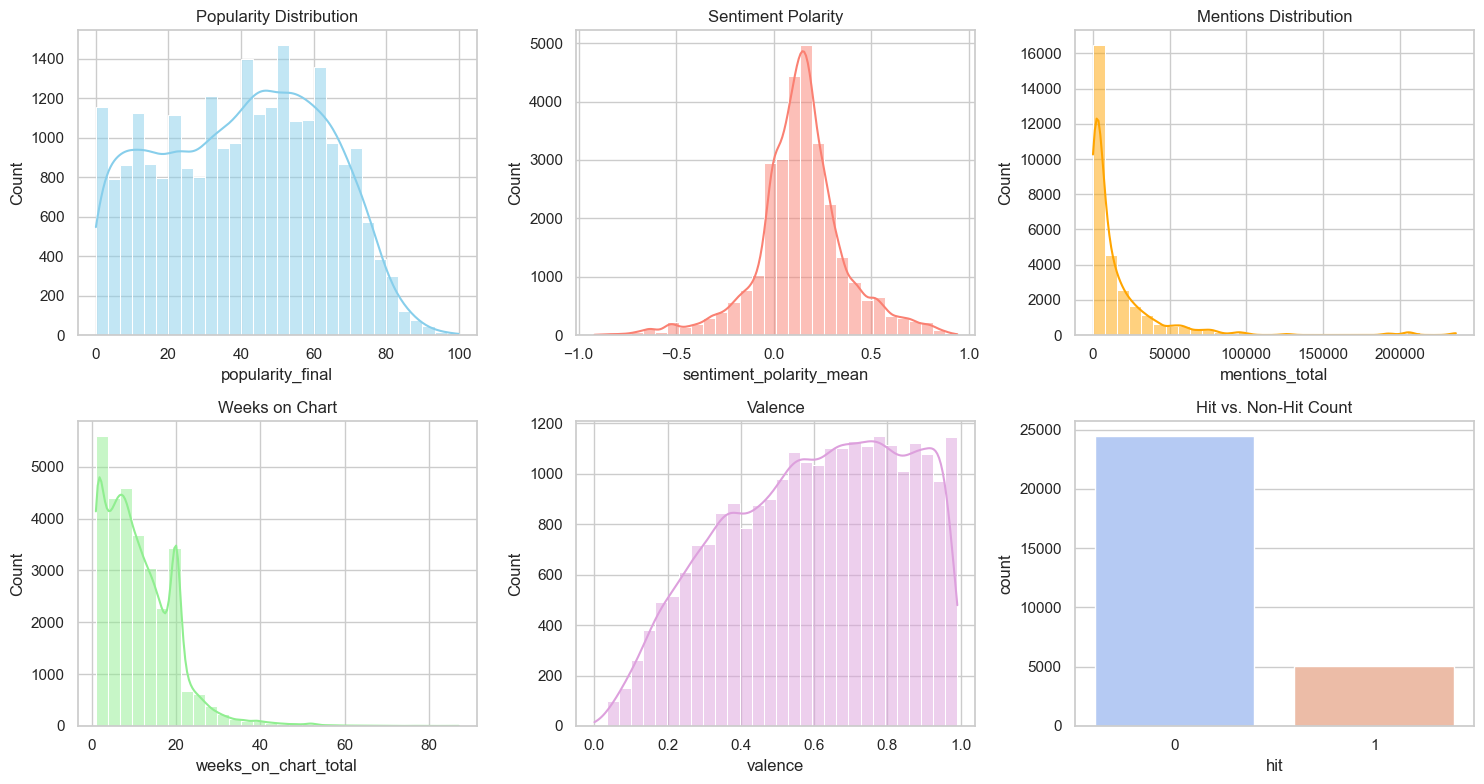

In [66]:
sns.set_theme(style="whitegrid")

# Key feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.histplot(merged["popularity_final"], bins=30, kde=True, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Popularity Distribution")

sns.histplot(merged["sentiment_polarity_mean"], bins=30, kde=True, ax=axes[0,1], color="salmon")
axes[0,1].set_title("Sentiment Polarity")

sns.histplot(merged["mentions_total"], bins=30, kde=True, ax=axes[0,2], color="orange")
axes[0,2].set_title("Mentions Distribution")

sns.histplot(merged["weeks_on_chart_total"], bins=30, kde=True, ax=axes[1,0], color="lightgreen")
axes[1,0].set_title("Weeks on Chart")

sns.histplot(merged["valence"], bins=30, kde=True, ax=axes[1,1], color="plum")
axes[1,1].set_title("Valence")

sns.countplot(x="hit", data=merged, ax=axes[1,2], hue="hit", palette="coolwarm", legend=False)
axes[1,2].set_title("Hit vs. Non-Hit Count")

plt.tight_layout()
plt.show()

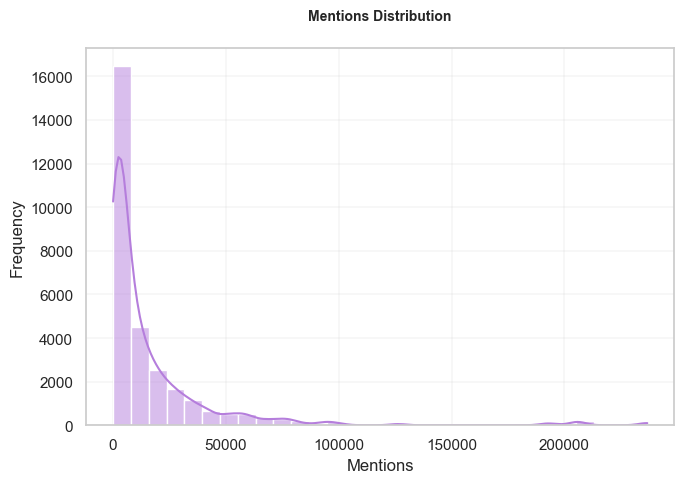

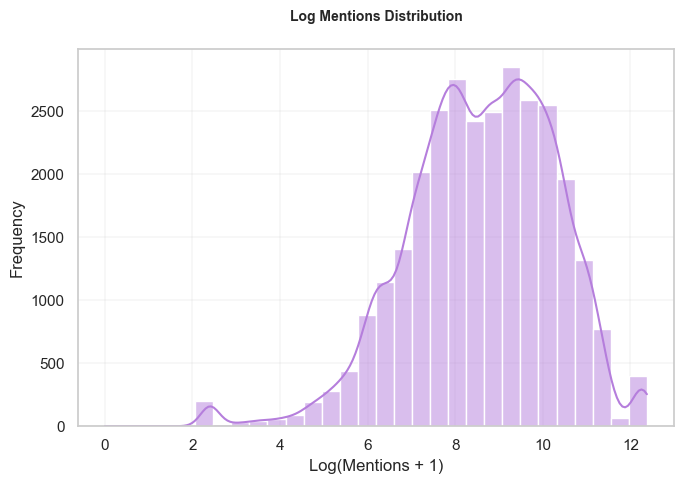

In [67]:
# Apply same theme and aesthetic
sns.set_theme(style="whitegrid")

# Plot: Mentions Distribution
plt.figure(figsize=(7, 5))
ax = sns.histplot(
    merged["mentions_total"],
    bins=30,
    kde=True,
    color="#b57edc",
    edgecolor="white"
)
ax.grid(True, linewidth=0.2)  # Make grid lines thinner
plt.title("Mentions Distribution", fontsize=10, weight="bold", pad=20)
plt.xlabel("Mentions")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot: Log Mentions Distribution
plt.figure(figsize=(7, 5))
ax = sns.histplot(
    np.log1p(merged["mentions_total"]),
    bins=30,
    kde=True,
    color="#b57edc",
    edgecolor="white"
)
ax.grid(True, linewidth=0.2)  # Make grid lines thinner
plt.title("Log Mentions Distribution", fontsize=10, weight="bold", pad=20)
plt.xlabel("Log(Mentions + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

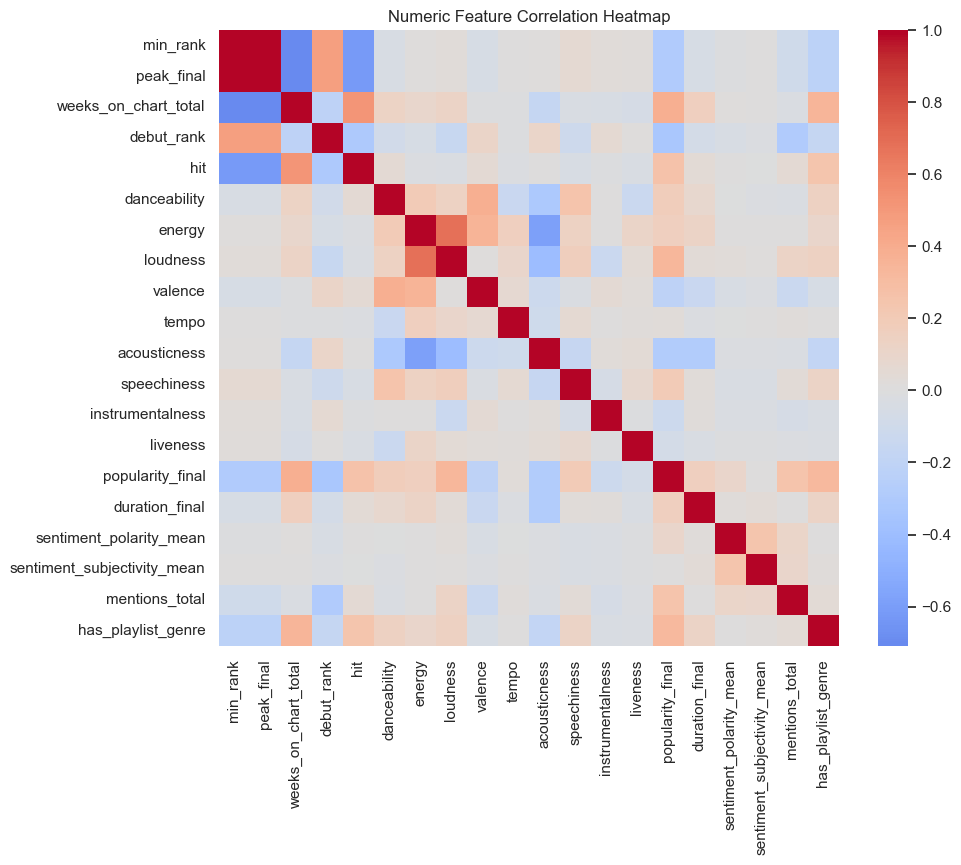

In [68]:
num_cols = merged.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(merged[num_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

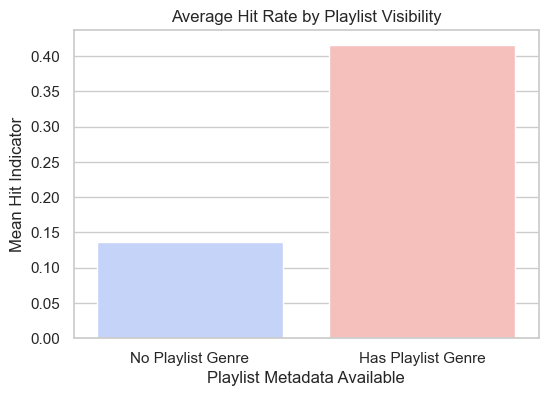

In [69]:
# Hit rate by playlist visibility with pleasant colors
pleasant_palette = ["#bbd0ff", "#FFB7B2"]  # soft green, soft pink

hit_rate = (
    merged.groupby("has_playlist_genre")["hit"]
    .mean()
    .rename({0: "No Playlist Genre", 1: "Has Playlist Genre"})
)

plt.figure(figsize=(6,4))
sns.barplot(x=hit_rate.index, y=hit_rate.values, hue=hit_rate.index, palette=pleasant_palette, legend=False)
plt.title("Average Hit Rate by Playlist Visibility")
plt.ylabel("Mean Hit Indicator")
plt.xlabel("Playlist Metadata Available")
plt.show()

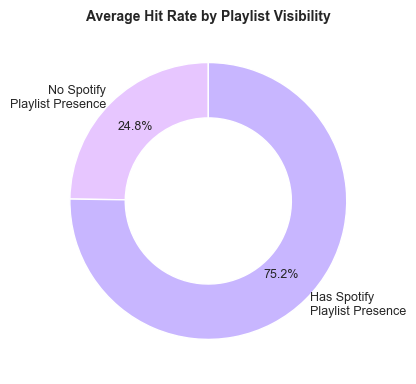

In [70]:
# Soft theme
sns.set_theme(style="whitegrid")

# Data prep
pleasant_palette = ["#e7c6ff", "#c8b6ff"]  # soft green, soft pink
hit_rate = (
    merged.groupby("has_playlist_genre")["hit"]
    .mean()
    .rename({0: "No Spotify\nPlaylist Presence", 1: "Has Spotify\nPlaylist Presence"})
)

# Donut chart
fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(
    hit_rate.values,
    labels=hit_rate.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=pleasant_palette,
    wedgeprops=dict(width=0.4, edgecolor="white"),
    textprops={"fontsize": 9, "weight": "regular"},
    pctdistance=0.75,      # Move value labels outward (default is 0.6)
    labeldistance=1.05     # Move category labels outward (default is 1.1)
)

# Center circle (donut hole)
centre_circle = plt.Circle((0, 0), 0.30, fc="white")
ax.add_artist(centre_circle)

# Title and polish
ax.set_title("Average Hit Rate by Playlist Visibility", fontsize=10, weight="bold", pad=5)
plt.tight_layout()
plt.show()


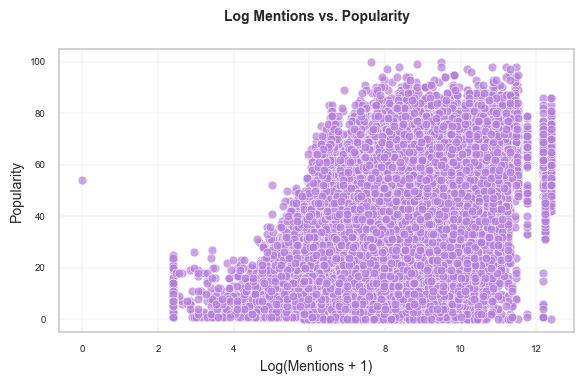

In [71]:
# ...existing code...
# Scatterplot: Log Mentions vs. Popularity
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
ax = sns.scatterplot(
    x=np.log1p(merged["mentions_total"]),
    y=merged["popularity_final"],
    color="#b57edc",
    edgecolor="white",
    s=40,         # marker size
    alpha=0.7     # marker transparency
)
ax.grid(True, linewidth=0.2)  # Thinner grid lines
plt.title("Log Mentions vs. Popularity", fontsize=10, weight="bold", pad=20)
plt.xlabel("Log(Mentions + 1)", fontsize=10)
plt.ylabel("Popularity", fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()
# ...existing code...

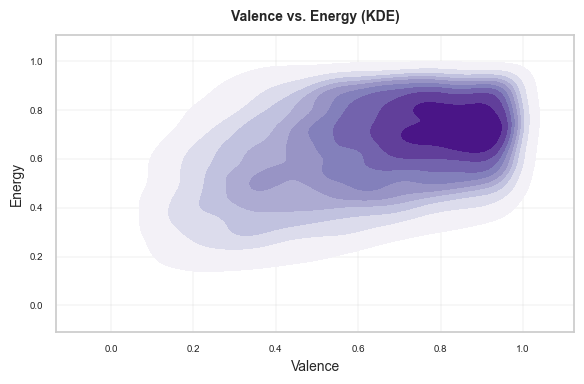

In [72]:
# KDE Plot: Valence vs. Energy
plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=merged,
    x="valence",
    y="energy",
    fill=True,
    thresh=0.05,
    cmap="Purples"
)

plt.title("Valence vs. Energy (KDE)", fontsize=10, weight="bold", pad=10)
plt.xlabel("Valence", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.2)  # Make grid lines thinner
plt.tight_layout()
plt.show()

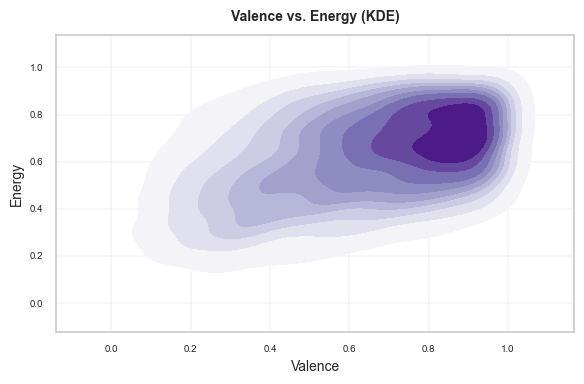

In [73]:
# KDE Plot: Valence vs. Energy
plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=merged[merged["hit"] == 1],
    x="valence",
    y="energy",
    fill=True,
    thresh=0.05,
    cmap="Purples"
)

plt.title("Valence vs. Energy (KDE)", fontsize=10, weight="bold", pad=10)
plt.xlabel("Valence", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.2)  # Make grid lines thinner
plt.tight_layout()
plt.show()

**EDA Interpretation Summary**

**1. Popularity Distribution**  
Nearly uniform up to ~70, then drops sharply — expected, as very few tracks achieve top-tier popularity.  
*Modeling note:* Suggests nonlinear patterns; a log or quantile transformation might help.

**2. Sentiment Polarity**  
Centered near 0 with mild right skew (mean ≈ +0.14).  
Most artists evoke slightly positive online sentiment.

**3. Mentions (log-scaled)**  
Log distribution looks close to normal, confirming heavy-tailed original count data.  
Indicates large social attention differences between average and viral artists.

**4. Weeks on Chart**  
Classic exponential decay: many short-lived entries, few long runs.  
Strongly correlated with min_rank and peak_final.

**5. Valence**  
Rises steadily to high positivity (≈0.7–0.9 range).  
Pop music trend: bright, upbeat tracks dominate.

**6. Hit vs. Non-Hit**  
~17% of entries are hits — moderate class imbalance (1:5 ratio).  
Important for model stratification or resampling later.

**7. Correlation Heatmap**  
Tight cluster among danceability, energy, valence, and loudness — redundant audio traits.  
`hit`, `popularity_final`, and `mentions_total` show mild positive association.  
`weeks_on_chart_total` inversely related to `min_rank` (as expected).

**8. Playlist Visibility**  
Huge jump in hit rate: ~13% → >40% when playlist metadata exists.  
Confirms Spotify playlist exposure is a strong success driver — can be treated as a categorical or binary feature.


### 5.3 Feature Engineering

1. log_mentions
2. popularity_norm
3. tempo_norm
4. sentiment_label (categorical)
5. genre_simplified (encoded)
6. sentiment_intensity
7. engagement_score
8. energy_valence_interaction
9. weeks_performance_log

In [74]:
# Basic Feature Transformations ---

# 1. Log-transform highly skewed counts
# We applied the logarithmic transformation to mentions_total 
# because the raw count distribution is heavily right-skewed
# (as we saw earlier — a few artists have hundreds of thousands
# of mentions, while most have just a few thousand or less).
merged["log_mentions"] = np.log1p(merged["mentions_total"])

# 2. Normalize popularity to 0–1 scale
merged["popularity_norm"] = merged["popularity_final"] / 100

# 3. Normalize tempo (BPM) for comparability with other audio metrics
merged["tempo_norm"] = merged["tempo"] / merged["tempo"].max()

# Quick sanity check
merged[["mentions_total", "log_mentions", "popularity_final",
        "popularity_norm", "tempo", "tempo_norm"]].describe().round(3)

,mentions_total,log_mentions,popularity_final,popularity_norm,tempo,tempo_norm
count,29488.000,29488.000,24479.000,24479.000,24419.000,24419.000
mean,16463.077,8.600,40.246,0.402,120.275,0.499
std,29750.767,1.675,22.478,0.225,28.052,0.116
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,1865.000,7.532,21.000,0.210,99.060,0.411
50%,6024.000,8.704,42.000,0.420,118.903,0.493
75%,18818.000,9.843,58.000,0.580,136.492,0.566
max,236713.000,12.375,100.000,1.000,241.009,1.000


In [75]:
# Sentiment Binning

def label_sentiment(p):
    if p < -0.1:
        return "negative"
    elif p <= 0.1:
        return "neutral"
    else:
        return "positive"

merged["sentiment_label"] = merged["sentiment_polarity_mean"].apply(label_sentiment)

# Verify distribution
merged["sentiment_label"].value_counts(normalize=True).round(3)


sentiment_label
positive    0.608
neutral     0.290
negative    0.102
Name: proportion, dtype: float64

In [76]:
# Inspect unique categorical fields
print("Unique genres:", merged["genre_final"].nunique())
print("Unique sentiment labels:", merged["sentiment_label"].unique())
print("Playlist genre flag values:", merged["has_playlist_genre"].value_counts())

Unique genres: 651
Unique sentiment labels: ['positive' 'neutral' 'negative']
Playlist genre flag values: has_playlist_genre
0    25959
1     3529
Name: count, dtype: int64


In [77]:
# Simplify genre_final into broad buckets

def simplify_genre(genre):
    if not isinstance(genre, str) or genre.strip() == "":
        return "unknown"
    g = genre.lower()
    if "pop" in g: return "pop"
    if "rock" in g: return "rock"
    if "hip hop" in g or "rap" in g: return "hiphop"
    if "r&b" in g or "soul" in g: return "rnb_soul"
    if "country" in g: return "country"
    if "latin" in g or "reggaeton" in g: return "latin"
    if "dance" in g or "edm" in g or "electronic" in g: return "edm"
    if "jazz" in g or "blues" in g: return "jazz_blues"
    if "metal" in g: return "metal"
    if "folk" in g: return "folk"
    return "other"

merged["genre_simplified"] = merged["genre_final"].apply(simplify_genre)

# Check new distribution
merged["genre_simplified"].value_counts(normalize=True).round(3)


genre_simplified
other         0.252
pop           0.190
rock          0.144
unknown       0.139
hiphop        0.087
rnb_soul      0.078
country       0.063
jazz_blues    0.013
metal         0.011
latin         0.009
folk          0.008
edm           0.007
Name: proportion, dtype: float64

In [78]:
# One-hot encode simplified genre and sentiment labels
merged = pd.get_dummies(
    merged,
    columns=["genre_simplified", "sentiment_label"],
    prefix=["genre", "sent"],
    drop_first=False
)

# Verify new encoded columns
encoded_cols = [c for c in merged.columns if c.startswith(("genre_", "sent_"))]
print(f"Added {len(encoded_cols)} encoded columns:")
print(encoded_cols)


Added 16 encoded columns:
['genre_final', 'genre_country', 'genre_edm', 'genre_folk', 'genre_hiphop', 'genre_jazz_blues', 'genre_latin', 'genre_metal', 'genre_other', 'genre_pop', 'genre_rnb_soul', 'genre_rock', 'genre_unknown', 'sent_negative', 'sent_neutral', 'sent_positive']


This feature combines polarity and subjectivity to capture how strong or emotionally expressive public sentiment is for each artist.

$\text{Sentiment Intensity} = |\text{Sentiment Polarity}| \times \text{Sentiment Subjectivity}$

In [79]:
# Sentiment Intensity
merged["sentiment_intensity"] = (
    merged["sentiment_polarity_mean"].abs() * merged["sentiment_subjectivity_mean"]
)
merged["sentiment_intensity"].describe().round(3)


count    29488.000
mean         0.060
std          0.069
min          0.000
25%          0.018
50%          0.039
75%          0.073
max          0.620
Name: sentiment_intensity, dtype: float64

This combines social volume and tone to approximate public engagement intensity.

$\text{Engagement Score} = \log(1 + \text{Mentions}) \times (\text{Sentiment Polarity} + 1)$

In [80]:
# Engagement Score
merged["engagement_score"] = merged["log_mentions"] * (merged["sentiment_polarity_mean"] + 1)
merged["engagement_score"].describe().round(3)

count    29488.000
mean         9.842
std          2.661
min          0.000
25%          8.375
50%         10.174
75%         11.667
max         18.592
Name: engagement_score, dtype: float64

This feature captures the emotional expressiveness of a track: energetic, upbeat songs vs. calm or somber ones.

$\text{Energy-Valence Interaction} = \text{Energy} \times \text{Valence}$

In [81]:
# Energy–Valence Interaction
merged["energy_valence_interaction"] = merged["energy"] * merged["valence"]
merged["energy_valence_interaction"].describe().round(3)

count    24419.000
mean         0.389
std          0.213
min          0.000
25%          0.211
50%          0.381
75%          0.550
max          0.946
Name: energy_valence_interaction, dtype: float64

Captures chart persistence adjusted for best rank achieved.

$\text{Weeks Performance} = \frac{\text{Weeks on Chart}}{\text{Min Rank}}$

In [82]:
# Weeks Performance Ratio
merged["weeks_performance"] = (
    merged["weeks_on_chart_total"] / merged["min_rank"]
)
merged["weeks_performance"].describe().round(3)

count    29488.000
mean         1.774
std          5.127
min          0.010
25%          0.067
50%          0.224
75%          0.833
max         76.000
Name: weeks_performance, dtype: float64

In [83]:
# Create a normalized version to handle the outlier 76
merged["weeks_performance_log"] = np.log1p(merged["weeks_performance"])
merged["weeks_performance_log"].describe().round(3)

count    29488.000
mean         0.522
std          0.757
min          0.010
25%          0.065
50%          0.202
75%          0.606
max          4.344
Name: weeks_performance_log, dtype: float64

### 5.4 Initial Feature Selection

In [84]:
# Numeric correlation diagnostics
num_cols = merged.select_dtypes(include=[np.number]).columns

corr_hit = merged[num_cols].corrwith(merged["hit"]).sort_values(ascending=False)
corr_pop = merged[num_cols].corrwith(merged["popularity_final"]).sort_values(ascending=False)

print("Top correlations with HIT:\n", corr_hit.head(10).round(3), "\n")
print("Top correlations with Popularity:\n", corr_pop.head(10).round(3))

Top correlations with HIT:
 hit                      1.000
weeks_performance_log    0.841
weeks_performance        0.630
weeks_on_chart_total     0.519
popularity_final         0.261
popularity_norm          0.261
has_playlist_genre       0.241
log_mentions             0.126
engagement_score         0.091
danceability             0.055
dtype: float64 

Top correlations with Popularity:
 popularity_final         1.000
popularity_norm          1.000
weeks_on_chart_total     0.385
log_mentions             0.365
weeks_performance_log    0.340
loudness                 0.339
has_playlist_genre       0.324
engagement_score         0.321
weeks_performance        0.270
hit                      0.261
dtype: float64


Classification: Predict hit (Yes/No) → logistic regression, XGBoostClassifier, etc.

Regression: Predict popularity_norm → linear regression, RandomForestRegressor, etc.

**With hit (binary target)**
| Feature                              | Correlation      | Insight                                                                                                                                                                                                                 |
|-------------------------------------- |-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| weeks_performance_log                 | 0.84      | Very strong — near-deterministic relation. Not surprising, since weeks_performance_log is derived from chart metrics (weeks_on_chart_total and min_rank), both components of “hit.” Remove when predicting hits to avoid leakage. |
| weeks_on_chart_total, weeks_performance| 0.52–0.63 | Similar leakage effect — these are “chart outcomes,” not pre-release predictors.                                                                                                                                        |
| popularity_final / _norm              | 0.26      | Reasonable — higher Spotify popularity correlates with Billboard success.                                                                                                         |
| has_playlist_genre                    | 0.24      | Reasonable — playlist inclusion aids hit probability.                                                                                                                          |
| log_mentions                          | 0.13      | Positive but moderate — social buzz matters, but not a sole determinant.                                                                                                          |
| engagement_score, danceability        | < 0.10    | Weak individual impact but may contribute in combination.                                                                                                                         |

**Interpretation:** Chart-derived features (weeks_\*) explain hit status directly (good for EDA, not for predictive modeling).
The actionable features for modeling are likely: popularity_norm, log_mentions, engagement_score, has_playlist_genre, energy_valence_interaction, sentiment_\*, and genre_\*.

**With popularity_final (Continuous)**
| Feature                                         | Corr      | Insight                                                                                      |
|-------------------------------------------------|-----------|----------------------------------------------------------------------------------------------|
| weeks_on_chart_total                            | 0.39      | Longer chart runs → higher Spotify popularity.                                               |
| log_mentions, has_playlist_genre, engagement_score | 0.32–0.37 | All capture fan attention and playlist exposure — great explanatory strength.                |
| loudness                                        | 0.34      | Popular tracks tend to be louder and more polished.                                          |
| weeks_performance_log                           | 0.34      | Logical overlap with chart performance.                                                      |
| hit                                             | 0.26      | As expected — popularity and hit overlap, but not identical.                                 |

**Interpretation:** Popularity blends both social and exposure factors; sentiment, mentions, and playlist visibility are practical predictive inputs.

In [85]:
# Variance Inflation Factor (VIF) Check
# focus on the core numeric predictors 
# (excluding chart-derived or target columns like hit, weeks_*, and popularity_final).

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select candidate numeric predictors
predictor_cols = [
    "danceability", "energy", "loudness", "valence", "tempo_norm",
    "acousticness", "speechiness", "instrumentalness", "liveness",
    "log_mentions", "sentiment_intensity", "engagement_score",
    "energy_valence_interaction"
]

# Drop missing values for VIF calculation
vif_df = merged[predictor_cols].dropna().copy()
X = add_constant(vif_df)

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
vif_data

,feature,VIF
0,const,211.923001
1,energy_valence_interaction,22.143812
2,valence,11.591822
3,energy,9.917352
4,log_mentions,4.163367
5,engagement_score,3.957125
6,loudness,2.254173
7,acousticness,1.775930
8,danceability,1.555301
9,sentiment_intensity,1.489822


**Modelling Summary**

**Model 1 — Classification (Billboard “Hit” = 1 or 0)**

**Goal:** Predict whether a track becomes a Billboard Top-10 hit.

**Model Types:**
- **Random Forest Classifier:** High accuracy, captures nonlinear effects
- **Logistic Regression:** Coefficient-level interpretability

**Keep:**
- **Audio:** `danceability`, `energy`, `loudness`, `acousticness`, `speechiness`, `instrumentalness`, `liveness`, `tempo_norm`
- **Behavioral & Sentiment:** `log_mentions`, `sentiment_intensity`, `engagement_score`
- **Exposure:** `has_playlist_genre`
- **Interaction (tree-based only):** `energy_valence_interaction`
- **Categoricals:** All `genre_*`, `sent_*` columns
- **Target:** `hit`

**Drop:**
- `weeks_on_chart_total`, `weeks_performance`, `weeks_performance_log`, `min_rank`, `peak_final` (leak chart info)
- `popularity_final`, `popularity_norm` (regression target only)

---

**Model 2 — Regression (Predict Popularity Score)**

**Goal:** Estimate continuous Spotify popularity (`popularity_norm`) as proxy for streaming success.

**Model Types:**
- **Random Forest Regressor:** Performance
- **Linear Regression:** Interpretability

**Keep:**
- Same as Model 1:
  - `danceability`, `energy`, `loudness`, `acousticness`, `speechiness`, `instrumentalness`, `liveness`, `tempo_norm`
  - `log_mentions`, `sentiment_intensity`, `engagement_score`, `has_playlist_genre`, `energy_valence_interaction`
  - All `genre_*`, `sent_*` columns
- **Target:** `popularity_norm`

**Drop:**
- `weeks_on_chart_total`, `weeks_performance`, `weeks_performance_log`, `min_rank`, `peak_final` (leak chart info)
- `hit` (classification target)

---

**Notes**
- Train Random Forest for performance.
- Train Logistic Regression on same data minus the interaction term for clear coefficient-based insights.
- Drop energy_valence_interaction for regression model to avoid multicollinearity.

**Summary Table**

| Model    | Type          | Algorithm(s)                        | Target          | Key Use                   | Interpretability                |
|----------|--------------|-------------------------------------|-----------------|---------------------------|---------------------------------|
| Model 1  | Classification| Random Forest + Logistic Regression | `hit`           | Identify hit likelihood   | High (Logistic Reg + SHAP)      |
| Model 2  | Regression    | Random Forest + Linear Regression   | `popularity_norm`| Predict streaming popularity| High (Linear Reg + SHAP)        |

## 6. Predictive Modeling

### 6.1 Data Preparation for Modeling

In [86]:
# Shared base features
base_features = [
    "danceability", "energy", "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "tempo_norm",
    "log_mentions", "sentiment_intensity", "engagement_score",
    "has_playlist_genre"
]

cat_features = [c for c in merged.columns if c.startswith(("genre_", "sent_")) and c not in ["genre_final"]]

# 1. For tree-based models (Random Forest)
features_tree = base_features + cat_features + ["energy_valence_interaction"]

# 2. For linear models (Logistic/Linear Regression)
features_linear = base_features + cat_features  # <-- interaction dropped


In [87]:
# Classification target
y_class = merged["hit"]

# Regression target
y_reg = merged["popularity_norm"]

# Train/test for tree-based models
X_train_tree_cls, X_test_tree_cls, y_train_cls, y_test_cls = train_test_split(
    merged[features_tree], y_class, test_size=0.2, random_state=42, stratify=y_class
)
X_train_tree_reg, X_test_tree_reg, y_train_reg, y_test_reg = train_test_split(
    merged[features_tree], y_reg, test_size=0.2, random_state=42
)

# Train/test for linear models
X_train_lin_cls, X_test_lin_cls, _, _ = train_test_split(
    merged[features_linear], y_class, test_size=0.2, random_state=42, stratify=y_class
)
X_train_lin_reg, X_test_lin_reg, _, _ = train_test_split(
    merged[features_linear], y_reg, test_size=0.2, random_state=42
)

In [88]:
# Final Data Imputation for Model Readiness

# Create a median imputer
imputer = SimpleImputer(strategy="median")

# Fit on training data, transform both train and test sets
X_train_lin_cls = pd.DataFrame(
    imputer.fit_transform(X_train_lin_cls),
    columns=X_train_lin_cls.columns,
    index=X_train_lin_cls.index
)

X_test_lin_cls = pd.DataFrame(
    imputer.transform(X_test_lin_cls),
    columns=X_test_lin_cls.columns,
    index=X_test_lin_cls.index
)

### 6.2 Model Training & Evaluation – Random Forest

In [89]:
# Inspect non-numeric columns
non_numeric = X_train_tree_cls.select_dtypes(exclude=["number"]).columns
print(non_numeric)

Index(['genre_country', 'genre_edm', 'genre_folk', 'genre_hiphop',
       'genre_jazz_blues', 'genre_latin', 'genre_metal', 'genre_other',
       'genre_pop', 'genre_rnb_soul', 'genre_rock', 'genre_unknown',
       'sent_negative', 'sent_neutral', 'sent_positive'],
      dtype='object')


In [90]:
# Train Random Forest Classifier
rf_cls = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_cls.fit(X_train_tree_cls, y_train_cls)

# Predictions & Probabilities
y_pred_cls = rf_cls.predict(X_test_tree_cls)
y_prob_cls = rf_cls.predict_proba(X_test_tree_cls)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, digits=3))

print("\nROC-AUC:", round(roc_auc_score(y_test_cls, y_prob_cls), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))


Classification Report:
              precision    recall  f1-score   support

           0      0.848     0.985     0.912      4893
           1      0.667     0.143     0.236      1005

    accuracy                          0.842      5898
   macro avg      0.758     0.564     0.574      5898
weighted avg      0.817     0.842     0.797      5898


ROC-AUC: 0.735

Confusion Matrix:
 [[4821   72]
 [ 861  144]]


<Figure size 1000x600 with 0 Axes>

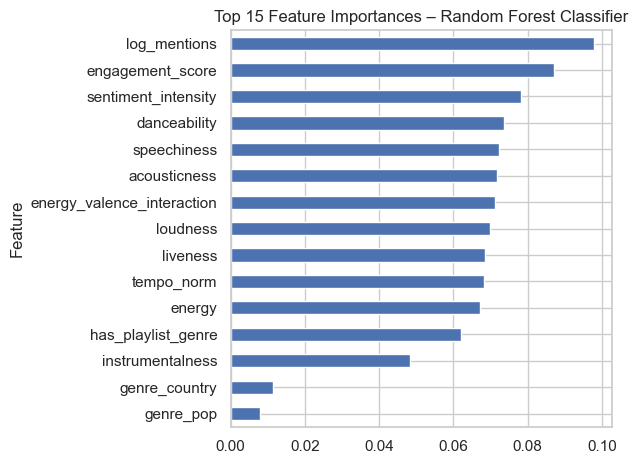

,Feature,Importance
8,log_mentions,0.097732
10,engagement_score,0.087087
9,sentiment_intensity,0.078207
0,danceability,0.073551
4,speechiness,0.072378
3,acousticness,0.071602
27,energy_valence_interaction,0.071152
2,loudness,0.069812
6,liveness,0.068425
7,tempo_norm,0.068315


In [91]:
# Get feature importance
imp_df = pd.DataFrame({
    "Feature": X_train_tree_cls.columns,
    "Importance": rf_cls.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
imp_df.head(15).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances – Random Forest Classifier")
plt.tight_layout()
plt.show()

imp_df.head(15)


**Random Forest (Hit Prediction)**

| Metric                | Value  | Interpretation                                                                 |
|-----------------------|--------|-------------------------------------------------------------------------------|
| Accuracy              | 0.842  | Overall correct predictions (mostly non-hits) are strong.                     |
| Precision (Hit = 1)   | 0.667  | When the model says “hit,” it’s right two-thirds of the time.                 |
| Recall (Hit = 1)      | 0.143  | It misses many true hits — classic imbalance effect (few positives).          |
| F1 (Hit)              | 0.236  | Low due to recall imbalance; can improve with resampling or threshold tuning. |

**Interpretation**  
The model is excellent at identifying non-hits (recall 0.985 for class 0) but conservative about labeling hits.  
That is good as it rarely “overhypes” i.e., it predicts hits only when it’s fairly confident.

---

**Feature Importance Insights**

Top drivers from Feature Importance (Random Forest):

- log_mentions — online buzz volume is the strongest predictor of success.
- engagement_score — sentiment-weighted attention boosts predictive strength.
- sentiment_intensity — emotional tone of discussion matters.
- danceability, speechiness, acousticness, energy_valence_interaction, loudness — audio traits shape listener response.
- has_playlist_genre — playlist exposure remains one of the most consistent success factors.
- Genres (genre_country, genre_pop) — mild genre-specific differences; pop dominance visible.

**Takeaway**  
Popularity and hit probability are driven more by social traction and exposure than by audio characteristics alone, though upbeat and energetic sound profiles still help.

**Future Scope**
- Optionally add temporal features (release year, decade trends).

SHAP value matrix shape: (1000, 28)


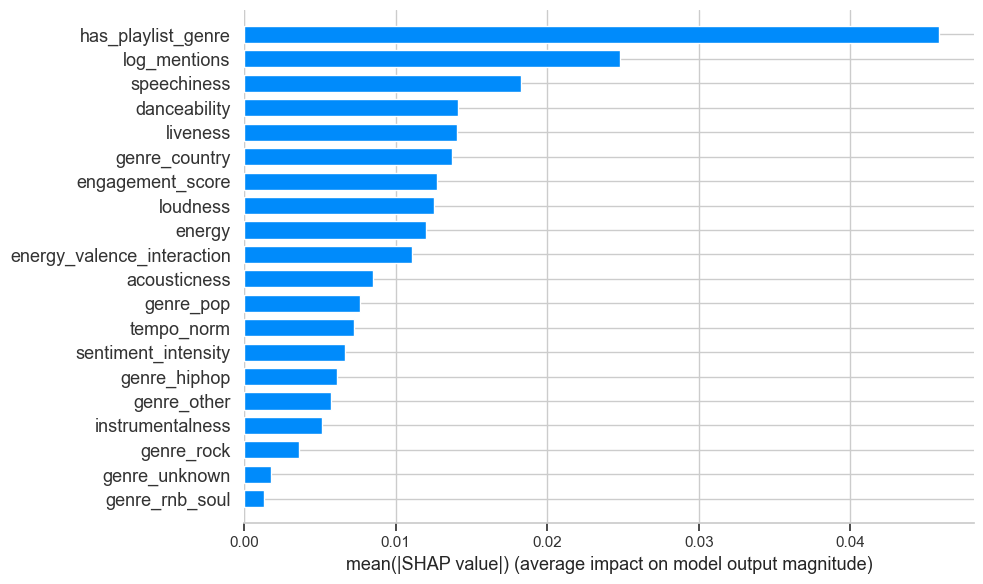

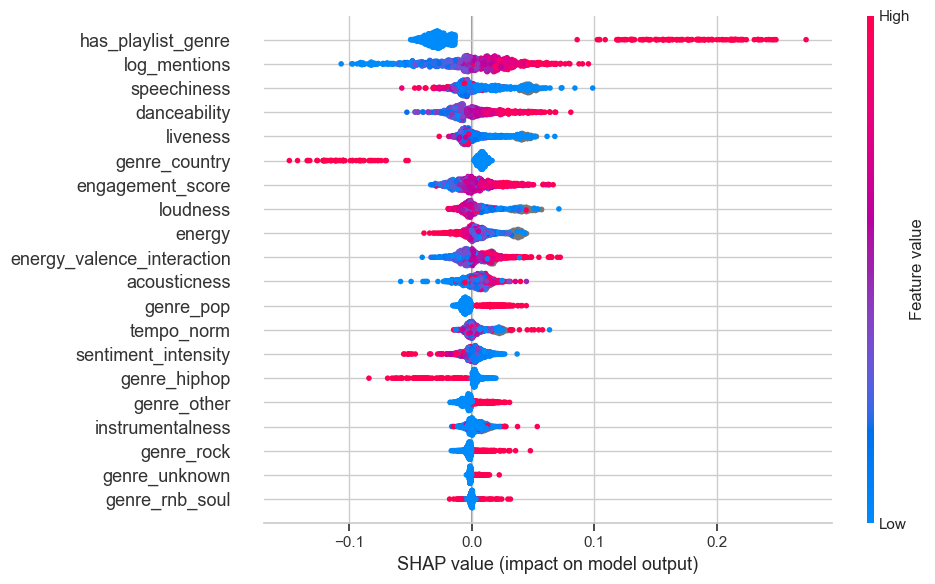

In [92]:
# SHAP Explainability for Random Forest Classifier

# Compute SHAP values for a sample (smaller subset for speed)
explainer_cls = shap.TreeExplainer(rf_cls, feature_perturbation="tree_path_dependent")
X_sample_cls = X_test_tree_cls.sample(1000, random_state=42)
shap_values_cls = explainer_cls.shap_values(X_sample_cls)

# Handle multi-output array
# shap_values_cls has shape (n_samples, n_features, 2)
shap_values_to_plot = shap_values_cls[:, :, 1]   # class 1 = "hit"

print("SHAP value matrix shape:", shap_values_to_plot.shape)

# Global SHAP summary plots
shap.summary_plot(shap_values_to_plot, X_sample_cls, plot_type="bar", plot_size=(10,6))
shap.summary_plot(shap_values_to_plot, X_sample_cls, plot_size=(10,6))

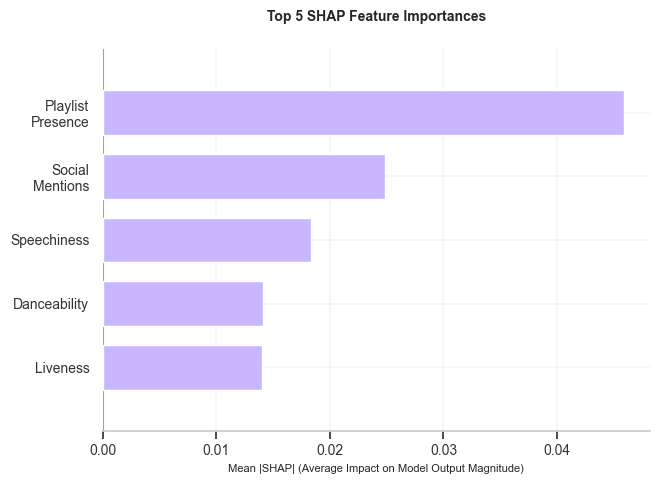

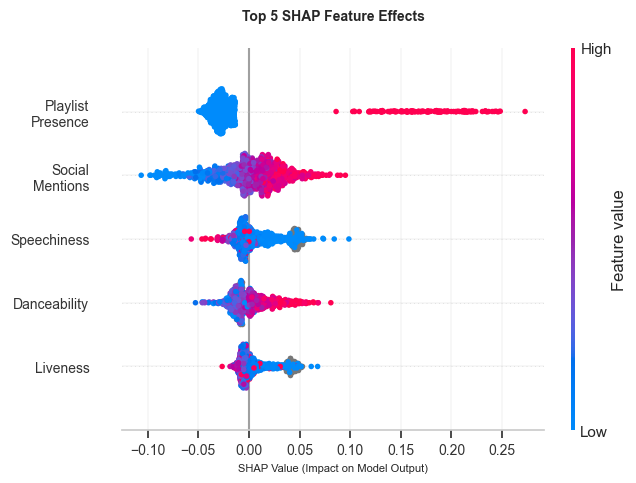

In [93]:
# Compute mean absolute SHAP values
mean_shap = np.abs(shap_values_to_plot).mean(axis=0)
top5_idx = np.argsort(mean_shap)[-5:][::-1]
top5_features = X_sample_cls.columns[top5_idx]

custom_names = [
    "Playlist\nPresence",  # has_playlist_genre
    "Social\nMentions",    # log_mentions
    "Speechiness",        # speechiness
    "Danceability",       # danceability
    "Liveness"            # liveness
]

# Bar Plot (Top 5)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
shap.summary_plot(
    shap_values_to_plot[:, top5_idx],
    X_sample_cls.iloc[:, top5_idx],
    feature_names=custom_names,
    plot_type="bar",
    plot_size=(7, 5),
    show=False,
    color="#c8b6ff"
)
plt.title("Top 5 SHAP Feature Importances", fontsize=10, weight="bold", pad=20)
plt.xlabel("Mean |SHAP| (Average Impact on Model Output Magnitude)", fontsize=8)
plt.grid(True, linewidth=0.2)
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Regular Summary Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
shap.summary_plot(
    shap_values_to_plot[:, top5_idx],
    X_sample_cls.iloc[:, top5_idx],
    feature_names=custom_names,
    plot_size=(7, 5),
    show=False
)
plt.title("Top 5 SHAP Feature Effects", fontsize=10, weight="bold", pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=8)
plt.grid(True, linewidth=0.2)
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**SHAP Interpretation — Random Forest Classifier (Hit Prediction)**

**1. Top Global Drivers**

The SHAP bar plot (mean |SHAP| values) ranks features by their influence on predicting a Billboard "hit":

| Rank | Feature                | Interpretation                                                                 |
|------|------------------------|-------------------------------------------------------------------------------|
| 1    | has_playlist_genre     | Playlist visibility is the dominant success factor. Tracks in curated playlists are much more likely to be hits. |
| 2    | log_mentions           | High online buzz or discussion volume strongly increases hit likelihood.      |
| 3    | speechiness            | Clear, articulate vocals slightly raise hit probability; listeners engage more with lyrical clarity. |
| 4–6  | danceability, liveness, genre_country | Upbeat and lively songs (or those in crossover country styles) gain moderate boosts. |
| 7–10 | engagement_score, loudness, energy, energy_valence_interaction | Listener engagement and production intensity also push songs toward success. |

Overall, exposure, engagement, and energy jointly drive hit outcomes.

---

**2. Directional Insights (Beeswarm Plot)**

- High feature values (red, right) increase hit probability.
- Low feature values (blue, left) decrease it.

**Key patterns:**
- Playlist presence (red, right): massive positive impact—songs featured in playlists are much more likely to chart.
- Mentions (red, right): higher social chatter pushes toward "hit".
- Loudness and energy: moderate positive impact (energetic mixes win).
- Acousticness (blue, left): highly acoustic songs reduce hit probability.
- Instrumentalness and genre_rnb_soul/rock (blue): less commercial mainstream appeal.

---

**3. Narrative Summary**

SHAP analysis confirms playlist placement and online attention are the strongest determinants of chart success.  
Production attributes (speechiness, danceability, loudness) further improve hit odds by aligning with mainstream listening patterns.  
More acoustic or instrumental tracks and niche genres contribute less to hit probability.

**Summary:**  
Visibility + Energy = Success; niche sound = lower mainstream impact.

### 6.2 Model Training & Evaluation – Logistic Regression

In [94]:
# Train Logistic Regression (balanced for class imbalance)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_lin_cls, y_train_cls)

# Predictions
y_pred_lr = log_reg.predict(X_test_lin_cls)
y_prob_lr = log_reg.predict_proba(X_test_lin_cls)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_lr, digits=3))
print("\nROC-AUC:", round(roc_auc_score(y_test_cls, y_prob_lr), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_lr))

# Coefficients & Odds Ratios
coef_df = pd.DataFrame({
    "Feature": X_train_lin_cls.columns,
    "Coefficient": log_reg.coef_[0],
})
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# View top 10 positive and negative drivers
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)
display(top_pos, top_neg)

Classification Report:
              precision    recall  f1-score   support

           0      0.902     0.666     0.766      4893
           1      0.284     0.647     0.395      1005

    accuracy                          0.662      5898
   macro avg      0.593     0.656     0.580      5898
weighted avg      0.797     0.662     0.703      5898


ROC-AUC: 0.723

Confusion Matrix:
 [[3257 1636]
 [ 355  650]]


,Feature,Coefficient,Odds_Ratio
11,has_playlist_genre,1.471473,4.355646
0,danceability,1.294954,3.650830
3,acousticness,0.470959,1.601530
20,genre_pop,0.364378,1.439618
8,log_mentions,0.246596,1.279662
19,genre_other,0.215057,1.239933
22,genre_rock,0.207088,1.230091
7,tempo_norm,0.072302,1.074980
23,genre_unknown,0.057767,1.059468
18,genre_metal,-0.010168,0.989883


,Feature,Coefficient,Odds_Ratio
1,energy,-0.101992,0.903036
6,liveness,-0.149162,0.861429
16,genre_jazz_blues,-0.340676,0.711289
9,sentiment_intensity,-0.396591,0.672609
15,genre_hiphop,-0.572365,0.564189
4,speechiness,-0.595372,0.551358
26,sent_positive,-0.615974,0.540115
25,sent_neutral,-0.738765,0.477703
24,sent_negative,-0.799475,0.449565
12,genre_country,-1.785800,0.167663


**Logistic Regression (Hit Prediction)**

Tested three optimization steps — SMOTE/ADASYN for class balance, feature scaling, and regularization tuning. None produced material gains beyond the baseline logistic regression (AUC ≈ 0.72, Recall ≈ 0.65). The model is stable and interpretable, indicating current performance is limited by feature signal rather than tuning.

**Performance Summary**

| Metric         | Value | Interpretation                                                        |
|----------------|-------|-----------------------------------------------------------------------|
| Accuracy       | 0.66  | Correct on two-thirds of tracks.                                      |
| Recall (Hits)  | 0.65  | Much higher than the Random Forest (0.14); model now finds most hits. |
| Precision      | 0.28  | More false positives; generous about calling a track a hit.           |
| ROC-AUC        | 0.72  | Roughly equal separability to the Random Forest (0.73).               |

**Interpretation**  
- Random Forest is conservative (high precision, low recall).  
- Logistic Regression is generous (lower precision, higher recall).

---

**Directional Insights (Coefficients → Odds Ratios)**

| Category      | Strong Drivers                | Interpretation (↑ Hit Odds)                                   |
|---------------|---------------------------------------|---------------------------------------------------------------|
| Exposure      | has_playlist_genre (OR 4.36)          | Playlist placement ≈ 4× higher chance of charting.            |
| Audio Feel    | danceability (3.65), acousticness (1.6)| Upbeat, danceable, clear sound attracts mainstream success.   |
| Genre         | genre_pop (1.44), genre_rock (1.23)   | Pop and mainstream-rock genres outperform others.             |
| Buzz          | log_mentions (1.28)                   | Each log-unit rise in mentions ≈ 28% higher hit odds.         |
| Genre         | genre_country (0.17), genre_jazz_blues (0.71), genre_hiphop (0.56) | Niche or less crossover-friendly genres under-index on Billboard Top 10. |
| Sentiment     | sent_negative (0.45), sent_neutral (0.48), sent_positive (0.54)    | Strong sentiments don’t guarantee chart success; |
| Audio Traits  | speechiness (0.55), liveness (0.86)    | Spoken-word or live acoustics correlate with lower hit odds.   |

**Key Takeaways**

- Playlist exposure and audience attention are decisive — being on curated playlists and widely mentioned online dramatically increases success probability.
- "Pop-energy" audio profile performs best — energetic, danceable, clean production wins.
- Genre still matters — Pop and Rock outperform Country, Jazz, or Hip-Hop in Billboard Top-10 likelihood.
- Sentiment plays a supporting role — it amplifies visibility and engagement, but doesn’t guarantee success alone. What truly drives hits is volume (mentions) and exposure (playlist presence). Sentiment strengthens those effects when aligned (e.g., strong positive buzz plus high mentions → most predictive).
- Both models identify the same pillars (playlist, mentions, energy); logistic adds clear direction and magnitude.

In [95]:
# Save the logistic regression model for the Predictor app
import joblib
output_path = DATA_DIR / "extracts/"

joblib.dump(log_reg, output_path / "log_reg_model.pkl")

# Save column structure for reference
X_train_lin_cls.columns.to_series().to_csv(output_path / "feature_columns.csv", index=False)

# Save summary stats to derive realistic slider ranges
X_train_lin_cls.describe(percentiles=[0.1, 0.5, 0.9]).to_csv(output_path / "feature_summary.csv")

In [96]:
# Create SHAP explainer using the model's predict_proba function
explainer_lr = shap.Explainer(log_reg.predict_proba, X_test_lin_cls, feature_names=X_test_lin_cls.columns)

# Compute SHAP values for the test set
shap_values_lr = explainer_lr(X_test_lin_cls)

print("SHAP values shape:", shap_values_lr.values.shape)

PermutationExplainer explainer: 5899it [00:59, 85.36it/s]                           


SHAP values shape: (5898, 27, 2)


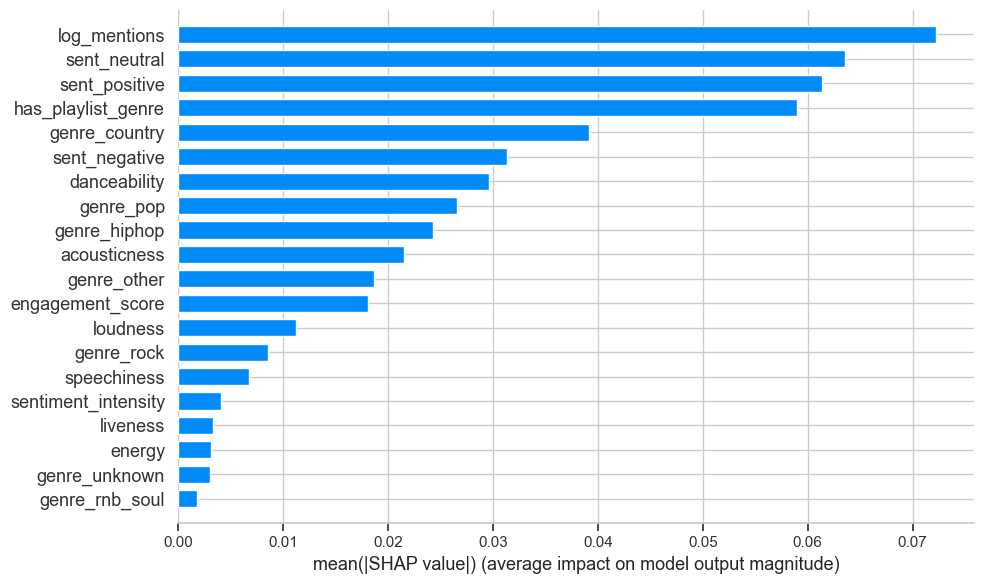

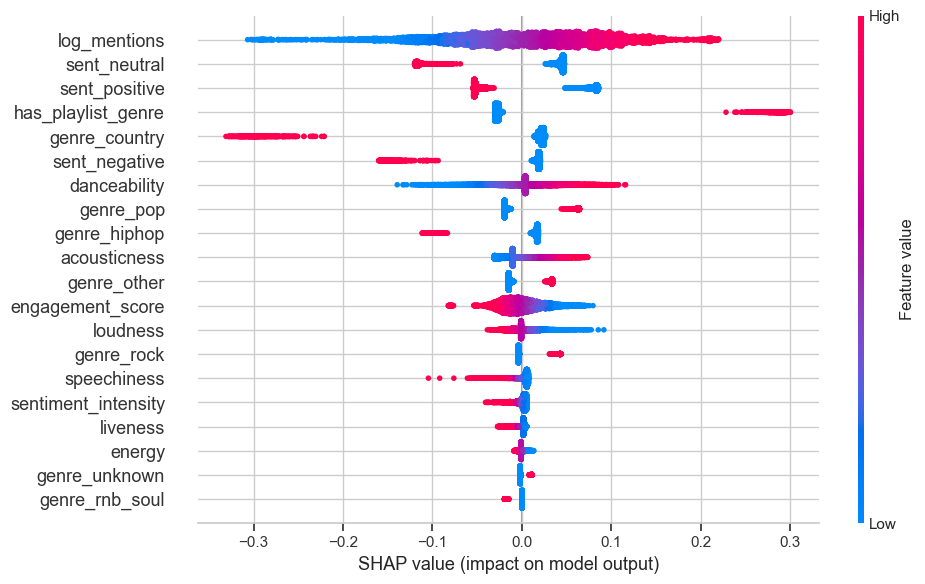

In [97]:
# Extract SHAP values for the "hit" class
shap_values_to_plot_lr = shap_values_lr.values[:, :, 1]

# Bar and beeswarm plots for global interpretation
shap.summary_plot(shap_values_to_plot_lr, X_test_lin_cls, plot_type="bar", plot_size=(10,6))
shap.summary_plot(shap_values_to_plot_lr, X_test_lin_cls, plot_size=(10,6))

**SHAP Interpretation — Logistic Regression**

**Top Global Drivers (Bar Plot)**

| Rank | Feature                        | Explanation                                                                 |
|------|------------------------------- |-----------------------------------------------------------------------------|
| 1    | log_mentions                   | The dominant predictor again — more online discussions raise hit probability.|
| 2–4  | sent_neutral, sent_positive, has_playlist_genre | Neutral and mildly positive sentiment both strengthen prediction; playlist exposure continues to boost hits. |
| 5    | genre_country                  | Country songs have slightly higher modeled hit odds (likely crossover influence). |
| 6–10 | sent_negative, danceability, genre_pop, genre_hiphop, acousticness | Emotional tone and rhythmic accessibility remain relevant but secondary.     |

**2. Directional Effects (Beeswarm Plot)**

- log_mentions: high values (red, right) push the model strongly toward "hit".
- sent_neutral & sent_positive: moderate or balanced sentiment language around songs contributes positively; extreme tone (too negative or too emotional) has less lift.
- has_playlist_genre: consistently positive; playlist presence raises success odds.
- genre_country / genre_pop: genres with mass appeal push "hit" probability upward.
- acousticness & speechiness: highly acoustic or spoken tracks lower hit likelihood (blue, left).

**3. What This Tells Us**

- Social attention and exposure dominate: mentions and playlist presence remain the most decisive factors across both models.
- Sentiment nuance matters: balanced or neutral sentiment performs best; overly emotional or polarized content doesn’t help.
- Audio profile still matters: danceable, moderately acoustic, and genre-mainstream tracks tend to perform better.

Synthesis vs. Random Forest

| Theme         | Random Forest         | Logistic Regression                |
|---------------|----------------------|------------------------------------|
| Top driver    | Playlist presence    | Social mentions                    |
| Sentiment     | Indirect via engagement | Direct and stronger linear influence |
| Audio traits  | Energy, loudness     | Danceability, acousticness         |
| Focus         | Exposure + sound intensity | Exposure + conversation tone      |

Together: Random Forest highlights how exposure and energy interact; Logistic Regression clarifies that conversation volume and balanced sentiment independently raise hit odds.

In [98]:
# Apply SMOTE to handle class imbalance before training Logistic Regression

# 1A. Initialize and apply SMOTE
smote = SMOTE(random_state=4, k_neighbors=3)
adasyn = ADASYN(random_state=42)
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_lin_cls, y_train_cls)

print(f"Original training set size: {X_train_lin_cls.shape}, Class distribution: {y_train_cls.value_counts().to_dict()}")
print(f"Resampled training set size: {X_train_res.shape}, Class distribution: {y_train_res.value_counts().to_dict()}")

# 1B. Train Logistic Regression on resampled data
log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)  # remove class_weight='balanced'
log_reg_smote.fit(X_train_res, y_train_res)

# 1C. Predictions on the original (unbalanced) test set
y_pred_lr = log_reg_smote.predict(X_test_lin_cls)
y_prob_lr = log_reg_smote.predict_proba(X_test_lin_cls)[:, 1]

# 1D. Evaluation
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_lr, digits=3))
print("\nROC-AUC:", round(roc_auc_score(y_test_cls, y_prob_lr), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_lr))

# 1E. Coefficients & Odds Ratios
coef_df = pd.DataFrame({
    "Feature": X_train_lin_cls.columns,
    "Coefficient": log_reg_smote.coef_[0],
})
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# View top 10 positive and negative drivers
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)
display(top_pos, top_neg)


Original training set size: (23590, 27), Class distribution: {0: 19570, 1: 4020}
Resampled training set size: (39140, 27), Class distribution: {0: 19570, 1: 19570}
Classification Report:
              precision    recall  f1-score   support

           0      0.904     0.660     0.763      4893
           1      0.284     0.659     0.397      1005

    accuracy                          0.660      5898
   macro avg      0.594     0.659     0.580      5898
weighted avg      0.798     0.660     0.700      5898


ROC-AUC: 0.722

Confusion Matrix:
 [[3228 1665]
 [ 343  662]]


,Feature,Coefficient,Odds_Ratio
0,danceability,1.574676,4.829176
11,has_playlist_genre,1.512084,4.536174
20,genre_pop,0.510361,1.665892
3,acousticness,0.488947,1.630598
19,genre_other,0.331452,1.392989
22,genre_rock,0.312119,1.366317
8,log_mentions,0.239500,1.270614
23,genre_unknown,0.171091,1.186599
7,tempo_norm,0.151245,1.163282
2,loudness,-0.020564,0.979646


,Feature,Coefficient,Odds_Ratio
5,instrumentalness,-0.400352,0.670084
16,genre_jazz_blues,-0.404813,0.667102
6,liveness,-0.461402,0.630399
15,genre_hiphop,-0.509095,0.601040
26,sent_positive,-0.679081,0.507083
25,sent_neutral,-0.801036,0.448864
24,sent_negative,-0.815516,0.442411
4,speechiness,-1.123959,0.324990
9,sentiment_intensity,-1.218726,0.295606
12,genre_country,-1.847965,0.157558


In [99]:
# STEP 2 + 3: Feature Scaling + Regularization Tuning with Grid Search
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Identify numeric and categorical columns
numeric_features = [
    'danceability', 'energy', 'acousticness', 'speechiness', 'liveness',
    'instrumentalness', 'sentiment_intensity', 'log_mentions', 'engagement_score'
]
numeric_features = [col for col in numeric_features if col in X_train_lin_cls.columns]

categorical_features = [col for col in X_train_lin_cls.columns if col not in numeric_features]

# Build preprocessing: scale numeric, pass categorical unchanged
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', 'passthrough', categorical_features)
])

# Define logistic regression & hyperparameter grid
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

param_grid = {
    'model__C': [0.01, 0.1, 1, 5, 10],
    'model__penalty': ['l2', 'l1'],
    'model__solver': ['liblinear']   # supports both L1 & L2
}

# Combine into pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_reg)
])

# Grid search for best regularization parameters
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train_lin_cls, y_train_cls)

# Best parameters and model
print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Predict on test data
y_pred_lr = best_model.predict(X_test_lin_cls)
y_prob_lr = best_model.predict_proba(X_test_lin_cls)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_lr, digits=3))
print("\nROC-AUC:", round(roc_auc_score(y_test_cls, y_prob_lr), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_lr))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0      0.902     0.667     0.767      4893
           1      0.285     0.648     0.396      1005

    accuracy                          0.664      5898
   macro avg      0.594     0.657     0.582      5898
weighted avg      0.797     0.664     0.704      5898


ROC-AUC: 0.723

Confusion Matrix:
 [[3263 1630]
 [ 354  651]]


### 6.2 Model Training & Evaluation – Random Forest Regressor

In [100]:
# Drop rows where popularity_norm is missing
clean_reg = merged.dropna(subset=["popularity_norm"]).copy()

# Recreate feature matrices for regression (only tree-based version for now)
X_tree_reg = clean_reg[features_tree]
y_tree_reg = clean_reg["popularity_norm"]

# Train-test split again
from sklearn.model_selection import train_test_split

X_train_tree_reg, X_test_tree_reg, y_train_reg, y_test_reg = train_test_split(
    X_tree_reg, y_tree_reg, test_size=0.2, random_state=42
)

R²:   0.504
RMSE: 0.156
MAE:  0.122


<Figure size 1000x600 with 0 Axes>

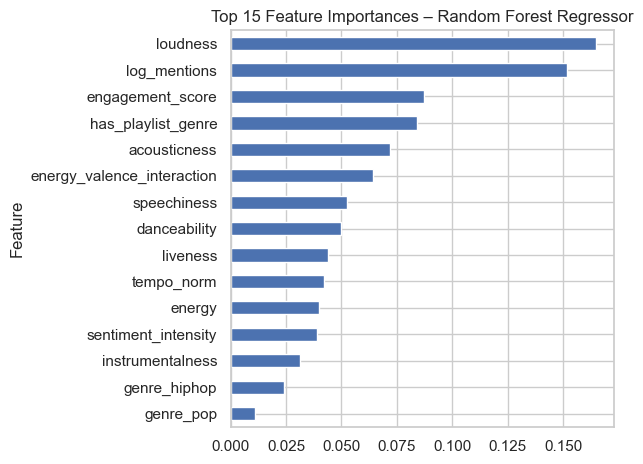

,Feature,Importance
2,loudness,0.164595
8,log_mentions,0.151422
10,engagement_score,0.086998
11,has_playlist_genre,0.084008
3,acousticness,0.071758
27,energy_valence_interaction,0.064302
4,speechiness,0.052311
0,danceability,0.049744
6,liveness,0.043888
7,tempo_norm,0.042036


In [101]:
# Train Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_tree_reg, y_train_reg)

# Predictions
y_pred_reg = rf_reg.predict(X_test_tree_reg)

# Evaluation metrics
r2 = r2_score(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print(f"R²:   {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")

# Feature importance
imp_df_reg = pd.DataFrame({
    "Feature": X_train_tree_reg.columns,
    "Importance": rf_reg.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
imp_df_reg.head(15).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances – Random Forest Regressor")
plt.tight_layout()
plt.show()

imp_df_reg.head(15)


**Random Forest Regressor (Popularity Prediction)**

**Model Performance**

| Metric      | Value         | Interpretation                                                                 |
|-------------|--------------|-------------------------------------------------------------------------------|
| R²          | 0.504        | Explains ~50% of variation in Spotify popularity — strong for behavioral + audio data. |
| RMSE        | 0.156        | Average prediction error ≈ 0.12 points on a 0–1 scale → reasonably tight.      |
| MAE         | 0.122        |                                                                              |

Summary:  
This model generalizes well, about half of what determines streaming popularity is captured, which is strong considering real-world unpredictability (marketing spend, release timing, etc. aren’t modeled here).

---

**Feature Importance Insights**

| Rank | Feature                        | Interpretation                                                        |
|------|------------------------------- |-----------------------------------------------------------------------|
| 1    | Loudness (0.165)               | Tracks that are professionally mixed and sonically powerful tend to stream better. |
| 2    | Log Mentions (0.151)           | Social buzz volume strongly correlates with streaming traction.        |
| 3    | Engagement Score (0.087)       | Sentiment-weighted attention boosts listener curiosity and sharing.    |
| 4    | Has Playlist Genre (0.084)     | Playlist inclusion increases exposure → higher play counts.            |
| 5    | Acousticness (0.072)           | Moderate acoustic clarity supports mass appeal; over-acoustic may hurt.|
| 6    | Energy Valence Interaction (0.064) | Energetic, emotionally bright songs perform better.                |
| 7–10 | Speechiness / Danceability / Liveness / Tempo Norm | Subtle rhythmic and performance elements influence engagement. |
| 11–13| Energy / Sentiment Intensity / Instrumentalness | Secondary factors; contribute but not primary drivers.           |
| 14–15| Genre Hip-hop / Pop            | Genre still matters but less than exposure or loudness.                |

---

**Key Takeaways**

- Production quality (Loudness) and Social traction (Mentions) are the dominant pillars of streaming success.
- Playlist exposure plays a critical amplifying role, echoing the hit-model findings.
- Emotional tone (Energy × Valence) contributes meaningfully but is secondary to visibility and sound quality.
- Genre alone has limited predictive power once behavioral and audio variables are included.

### 6.2 Model Training & Evaluation – Linear Regression

In [102]:
# Drop any rows with missing popularity_norm
clean_reg = merged.dropna(subset=["popularity_norm"]).copy()

# Rebuild features (no interaction term for linear model)
X_linear_reg = clean_reg[features_linear]
y_linear_reg = clean_reg["popularity_norm"]

# Split
from sklearn.model_selection import train_test_split
X_train_lin_reg, X_test_lin_reg, y_train_reg, y_test_reg = train_test_split(
    X_linear_reg, y_linear_reg, test_size=0.2, random_state=42
)

# Now safely apply median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

X_train_lin_reg = pd.DataFrame(
    imputer.fit_transform(X_train_lin_reg),
    columns=X_train_lin_reg.columns,
    index=X_train_lin_reg.index
)
X_test_lin_reg = pd.DataFrame(
    imputer.transform(X_test_lin_reg),
    columns=X_test_lin_reg.columns,
    index=X_test_lin_reg.index
)

In [103]:
# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_lin_reg, y_train_reg)

# Predictions
y_pred_lin = lin_reg.predict(X_test_lin_reg)

# Evaluation metrics
r2 = r2_score(y_test_reg, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_lin))
mae = mean_absolute_error(y_test_reg, y_pred_lin)

print(f"R²:   {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")

# Coefficients
coef_df = pd.DataFrame({
    "Feature": X_train_lin_reg.columns,
    "Coefficient": lin_reg.coef_
}).sort_values(by="Coefficient", ascending=False)

# Top positive & negative drivers
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)
display(top_pos, top_neg)


R²:   0.410
RMSE: 0.171
MAE:  0.136


,Feature,Coefficient
4,speechiness,0.219967
9,sentiment_intensity,0.179243
11,has_playlist_genre,0.133372
18,genre_metal,0.119988
0,danceability,0.099425
15,genre_hiphop,0.056955
17,genre_latin,0.053303
12,genre_country,0.052329
13,genre_edm,0.036853
8,log_mentions,0.033016


,Feature,Coefficient
26,sent_positive,-0.009122
5,instrumentalness,-0.019537
14,genre_folk,-0.021546
6,liveness,-0.046600
19,genre_other,-0.058677
21,genre_rnb_soul,-0.072831
16,genre_jazz_blues,-0.086865
23,genre_unknown,-0.098566
3,acousticness,-0.120488
1,energy,-0.214444


**Linear Regression (Popularity Prediction, Interpretable Version)**

**Model Performance**

| Metric         | Value           | Interpretation                                                                 |
|----------------|----------------|-------------------------------------------------------------------------------|
| R²             | 0.41            | Explains ~41% of variance in Spotify popularity. Slightly lower than Random Forest (0.50), as linear models can’t capture nonlinear interactions. |
| RMSE, MAE      | 0.171, 0.136    | Average error ≈ 0.13–0.17 points on a 0–1 scale — acceptable for interpretive analysis. |

**Summary:**  
Predictive power drops slightly versus the tree model.

---

**Directional Insights (Coefficients)**

| Category         | Drivers           | Interpretation                                                      |
|------------------|-----------------------------------------------|---------------------------------------------------------------------|
| Audio Traits     | speechiness (+0.22), danceability (+0.10)      | Lyrically expressive and rhythmically engaging tracks stream better. |
| Sentiment/Attention | sentiment_intensity (+0.18), log_mentions (+0.03) | Stronger emotional tone and more online discussion lift visibility.  |
| Exposure         | has_playlist_genre (+0.13)                     | Playlist exposure consistently boosts listenership.                  |
| Genres           | genre_metal, genre_hiphop, genre_latin, genre_country, genre_edm | Mild positive lift vs. baseline (“other”).                          |
| Audio Traits     | energy (–0.21), acousticness (–0.12), instrumentalness (–0.02), liveness (–0.05) | Overly energetic, acoustic, or live-session sounds reduce appeal.   |
| Genres           | genre_jazz_blues, genre_rnb_soul, genre_unknown, genre_folk, genre_other | Niche or less commercial genres underperform.                       |
| Sentiment Polarity | sent_positive (–0.009)                      | Emotional positivity alone isn’t predictive once exposure and mentions are controlled. |



**Unified Interpretation (Comparing 2A vs 2B)**

| Finding        | Random Forest                    | Linear Regression                | Combined Insight                                      |
|----------------|----------------------------------|----------------------------------|-------------------------------------------------------|
| Exposure       | Top driver (has_playlist_genre)  | Strong positive coefficient      | Playlist inclusion reliably drives visibility/streams.|
| Social Buzz    | log_mentions, engagement_score   | log_mentions, sentiment_intensity| Volume of conversation > tone; emotional engagement adds incremental lift. |
| Audio Profile  | loudness, energy_valence_interaction | speechiness, danceability, moderate energy | Balanced, rhythmic, lyric-centric songs perform better than overly loud or purely acoustic ones. |
| Genre Effects  | Minor                            | Mixed directional                | Genre helps but is secondary once behavioral signals are known. |

---

**Key Takeaways**

- Exposure and audience conversation dominate popularity.
- Balanced sonic design — danceable and moderately energetic — outperforms extremes.
- Sentiment intensity amplifies attention, but tone alone doesn’t predict success.
- Genres modulate but don’t determine performance.

## 7. Real-Time Dashboard (Streamlit)